# Automatic Diagnosis Generation Given Chest X-rays ML Pipeline

In [1]:
# mounting drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
drive_path = '/content/gdrive/My Drive/Assignments_Drive/Case_Study_2/Medical_Data'
# specifying paths
txt_path = drive_path + '/ecgen'
img_path = drive_path + '/images'

Mounted at /content/gdrive


In [2]:
from IPython.display import Javascript
display(Javascript('IPython.notebook.execute_cells_below()'))
import warnings
warnings.filterwarnings('ignore')

<IPython.core.display.Javascript object>

In [3]:
# imports
#!pip install tensorflow-gpu==2.3
#!pip install scikit-learn==0.20.4
# !wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
# !wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.txt.gz"

# from tensorflow.python.framework import ops
# ops.disable_eager_execution()

import os
from os import listdir
import io
import time
import re
import random
import pandas as pd
import numpy as np
from numpy import zeros
from numpy import array
from numpy import asarray
from numpy import save
from bs4 import BeautifulSoup
from tqdm import tqdm
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from PIL import Image
from pickle import dump
from pickle import load 
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
from gensim.models import word2vec
from gensim.models import Word2Vec

import sklearn
print(sklearn.__version__)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import pickle


import tensorflow 
print(tensorflow.__version__)
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense 
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1
from tensorflow.keras.backend import categorical_crossentropy
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Flatten

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
# setting the random seeds
SEED = 4
os.environ['PYTHONHASHSEED']=str(SEED)
#os.environ['TF_CUDNN_DETERMINISTIC'] = '4'  # new flag present in tf 2.0+
np.random.seed(SEED)
tensorflow.random.set_seed(SEED)

0.20.4
2.4.0


## Load Data

In [4]:
# read data from the pickle file
data = pd.read_pickle(drive_path + '/data_final.pkl')
#data = pd.read_pickle(drive_path + '/data_final.pkl')
print(data.shape)

(2610, 6)


In [5]:
with open(drive_path + '/impression_tokenizer.pickle', 'rb') as handle:
    impression_tokenizer = pickle.load(handle)

with open(drive_path + '/embedding_matrix_impression.pickle', 'rb') as handle:
    embedding_matrix_impression = pickle.load(handle)

embedding_dim = 100
pad_length_impression = 40
units = 256
vocab_tar_size = len(impression_tokenizer.word_index)+1
impression_matrix = embedding_matrix_impression

In [6]:
# get the uid and Image Pairs

data_pairs = data[['UID','IMAGES']]

## Load Model

In [7]:
# this class is for the x-ray features encoder 
class Encoder_Xray(tensorflow.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(Encoder_Xray, self).__init__()
        # shape after fc == (batch_size, embedding_dim)
        self.fc = tensorflow.keras.layers.Dense(embedding_dim, kernel_regularizer=l2)

    def call(self, x):
        x = self.fc(x)
        x = tensorflow.nn.relu(x)
        return x

In [8]:
# this class is for the xray features Attention
class BahdanauAttention_Xray(tensorflow.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention_Xray, self).__init__()
        self.W1 = tensorflow.keras.layers.Dense(units)
        self.W2 = tensorflow.keras.layers.Dense(units)
        self.V = tensorflow.keras.layers.Dense(1)
        self.add = tensorflow.keras.layers.Add()

    def call(self, features, hidden):
        
        # features (Xray_encoder output) shape == (batch_size, embedding_dim)
        # hidden shape == (batch_size, hidden_size)

        # features_xray shape == (batch_size, units)
        features_xray = self.W1(features)
        # features_hidden shape == (batch_size, units)
        features_hidden = self.W2(hidden)
        # features_add shape == (batch_size, units)
        features_add = features_xray + features_hidden
        # score shape == (batch_size, units)
        score = tensorflow.nn.tanh(features_add)
        # features_score shape == (batch_size, 1)
        features_score = self.V(score)
        # attention_weights shape == (batch_size, 1)
        attention_weights = tensorflow.nn.softmax(features_score, axis=1)
        # context_vector shape after sum == (batch_size, embedding_dim)
        context_vector = attention_weights * features

        return context_vector
    

In [9]:
class Decoder(tensorflow.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units = units

        self.embedding = tensorflow.keras.layers.Embedding(vocab_size, embedding_dim, weights=[impression_matrix], mask_zero=True)
        self.gru = tensorflow.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform',
                                   kernel_regularizer=l2, recurrent_regularizer=l2)
        self.fc1 = tensorflow.keras.layers.Dense(self.units, activation='relu', kernel_regularizer=l2)
        self.fc2 = tensorflow.keras.layers.Dense(vocab_size, kernel_regularizer=l2)

        self.attention1 = BahdanauAttention_Xray(self.units)
        self.attention2 = BahdanauAttention_Xray(self.units)


    def call(self, x = np.zeros((1,1)), features1 = np.zeros((1,100)), features2 = np.zeros((1,100)), hidden = np.zeros((1,256))):
        # defining attention as a separate model
        context_vector1 = self.attention1(features1, hidden)
        context_vector2 = self.attention2(features2, hidden)
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        x = tensorflow.concat([tensorflow.expand_dims(context_vector1, 1), tensorflow.expand_dims(context_vector2, 1), x], axis=-1)
        # x shape after concatenation == (batch_size, 1, embedding_dim + embedding_dim + embedding_dim)
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)
        # x_shape == (batch_size * max_length, hidden_size)
        x = tensorflow.reshape(x, (-1, x.shape[2]))
        # output_shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state

    def reset_state(self, batch_size):
        return tensorflow.zeros((batch_size, self.units))

In [10]:
encoder1 = Encoder_Xray(embedding_dim)
encoder2 = Encoder_Xray(embedding_dim)
decoder = Decoder(embedding_dim, units, vocab_tar_size)

In [11]:
encoder1.load_weights(drive_path + '/encoder1_weights')
encoder2.load_weights(drive_path + '/encoder2_weights')
decoder.load_weights(drive_path + '/decoder_weights')

## Utility Functions

In [13]:
def get_dataframe(xml_files):
    # now lets read each xml file and create a dataframe fron the data 

    # rows th the dataframe
    # 1. UID : The unique file id for each xml file
    # 2. FINDINGS : The findings that the doctor writes after viewing the x-rays of the patient
    # 3. NS_FINDINGS : The number of sentences in the findings section
    # 4. IMPRESSIONS : The final diagnosys that the doctor writes
    # 5. NS_IMPRESSIONS : The number of sentences in the impression section
    # 4. IMAGES : The list of images that are associated with a report
    # 7. NO_IMAGES : The number of images in a report

    # This list will be used to used store the contents of each xml file
    rows_list = []
    for xmlfile in xml_files:
        # file path stores the path of the xml files
        filepath = txt_path + '/' + xmlfile
        # this dict is used to contents of a xml file as {tag: value}
        dict_row = {}
        with open(filepath, "r") as f:
            # reading the file
            contents = f.read()
            # here we use lxml to parse the contents of xml file
            soup = BeautifulSoup(contents, 'lxml')
            # this piece of code is used to find the id associated with each file
            uid_tags = soup.findAll('uid')
            # extract the uid from tag and put the uid in the directory
            # this piece of code will check if there are more than one uids in the xml
            cnt = 0
            for ut in uid_tags:
                # increase cnt value
                cnt +=1
                # check if more than one ids are present
                if cnt > 1:
                    # prit and break
                    print('more than one ids')
                    break
                # get the uid value
                file_id = ut.get('id')
                # put the value in the directory
                dict_row['UID'] = file_id
            # this piece of code extracts the text from the xml file where the tag is abstracttext  
            tags = soup.findAll(['abstracttext'])
            for t in tags:
                # extract labels
                label=t.get("label")

                # extract the FINDINGS 
                if label=='FINDINGS':
                    f_text=t.text
                    # put the values in a directory 
                    dict_row['FINDINGS'] = f_text
                    #lets add the no. of sentences 
                    # first we need to add a fullstop to the end in case the doctor forgot to put it
                    if f_text.endswith('.'):
                        f_sen = f_text.split('.')
                    else:
                        f_text = f_text + '.'
                        f_sen = f_text.split('.')
                    # array to store the sentences
                    sent_arr = []
                    for sent in f_sen:
                        # check if the sentence is blank
                        if sent != '':
                            # append the array
                            sent_arr.append(sent)
                    # find no. of sentences 
                    ns_findings = len(sent_arr)
                    # add f_sen to the directory
                    dict_row['NS_FINDINGS'] = ns_findings
            
                # extract the IMPRESSION 
                if label=='IMPRESSION':
                    i_text=t.text
                    i_text = '<start> ' + i_text + ' <end>'
                    # put the values in a directory 
                    dict_row['IMPRESSION'] = i_text
                    # lets add the no. of sentences 
                    # first we need to add a fullstop to the end in case the doctor forgot to put it
                    i_text = i_text + '.'
                    i_sen = i_text.split('.')
                    # array to store the sentences
                    sent_arr = []
                    for sent in i_sen:
                        # check if the sentence is blank
                        if sent != '':
                            # append the array
                            sent_arr.append(sent)
                    # find no. of sentences 
                    ns_impression = len(sent_arr)
                    # add f_sen to the directory
                    dict_row['NS_IMPRESSION'] = ns_impression

            # This piece of code will extract the image names from the XML files
            itags = soup.findAll(['parentimage'])
            # this array will hold the images in a xml file as there are more than one images in a xml file
            x_ray_images = []
            # for each image in the file we will put it in the array
            for element in itags:
                # extract the image name from the file
                x_ray = element.get('id')
                # append the array
                x_ray_images.append(x_ray)
            #finally put the array in the row dict
            dict_row['IMAGES'] = x_ray_images
            # lets find the no of images in a xml file
            no_images = len(x_ray_images)
            # add this to the dict
            dict_row['NO_IMAGES'] = no_images

        # append the dict to the row (for each xml file we will have a dict_row(dict of data) in the rows_list)
        rows_list.append(dict_row)

    # finally create a dataframe from the rows_list
    df = pd.DataFrame(rows_list); df = df[['UID','IMPRESSION']]
    return df

In [14]:
# extract features from each x-ray in the directory
def extract_features(img_pair):
	# get the files
	files = img_pair
	# load the model
	# loading and re-structureing the model final shape = (1,1024)
	input_shape = (224, 224, 3)
	img_input = Input(shape=input_shape)
	base_model = DenseNet121(
		include_top=False,
		input_tensor=img_input,
		input_shape=input_shape,
		pooling="avg")
	x = base_model.output
	predictions = Dense(14, activation="sigmoid", name="predictions")(x)
	model = Model(inputs=img_input, outputs=predictions)
	model.load_weights(drive_path + '/CheXNet_weights.h5')
	model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

	# extract features from each photo
	features = dict(); features_list = list()
	l = len(files); idx = 0
	for name in files:
		
		# load an image from file
		filename = img_path + '/' + name + '.png'
		# get image id and file type
		image_id = name
		
		image = load_img(filename, target_size=(224, 224, 3))
		# convert the image pixels to a numpy array
		image = img_to_array(image)
		# reshape data for the model
		image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
		# prepare the image for the model
		image = preprocess_input(image)
		# get features
		feature = model(image, training = False)
		# store feature
		# store in the np array with the image_id
		#temp = [image_id,feature]
		#features_list.append(temp) 
  		# store in the dict
		features[image_id] = feature
	# validation
	
	return features

In [15]:
# this function will do greedy search
def greedy_search(img1, img2, target):
    # reset hidden states
    hidden = decoder.reset_state(batch_size=1)
    # reshape img vectors
    img1 = tensorflow.keras.backend.reshape(img1, shape=(1, -1))
    img2 = tensorflow.keras.backend.reshape(img2, shape=(1, -1))
    # get image features
    features1 = encoder1(img1)
    features2 = encoder2(img2)
    # decoder input = start
    dec_input = tensorflow.expand_dims([impression_tokenizer.word_index['<start>']], 0)
    result = []
    result.append('<start>')
    # loop for pad length
    for i in range(pad_length_impression):
        
        # get predections
        predictions, hidden = decoder(dec_input, features1, features2, hidden)
        # get argmax of predicted id
        predicted_id = predictions.numpy().argmax()
        result.append(impression_tokenizer.index_word[predicted_id])
        # if end is reached return
        if impression_tokenizer.index_word[predicted_id] == '<end>':
            return result
        # predicted output = next input
        dec_input = tensorflow.expand_dims([predicted_id], 0)
    # return
    return result


In [16]:
# this function will do beam search
def beam_search(img1, img2, target, beam_width = 5):

    # reset hidden states
    hidden = decoder.reset_state(batch_size=1)
    # reshape img vectors
    img1 = tensorflow.keras.backend.reshape(img1, shape=(1, -1))
    img2 = tensorflow.keras.backend.reshape(img2, shape=(1, -1))
    # get image features
    features1 = encoder1(img1)
    features2 = encoder2(img2)
    # decoder input = start
    start = [impression_tokenizer.word_index['<start>']]
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < pad_length_impression:
        temp = []
        for s in start_word:
            
            dec_input = pad_sequences([[s[0][-1]]])
            # get the predections 
            preds, hidden = decoder(dec_input, features1, features2, hidden)
            
            # Getting the top <beam_width>(n) predictions
            top_words = np.argsort(preds).flatten()
            word_preds = top_words[-beam_width:]
            
            # creating a new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_width:]
    
    # update start word
    start_word = start_word[-1][0]
    # intermediate caption
    intermediate_caption = [impression_tokenizer.index_word[i] for i in start_word]
    # generate final captions
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break
    # return final captions
    final_caption = final_caption[1:]
    final_caption.insert(0, '<start>')
    if len(final_caption) <= 39:
        final_caption.append('<end>')
    return final_caption

## Call to ML Pipeline

In [18]:
def final_function(dataset):
    # get the data pair values
    z = dataset.values
    # extract text file
    xmlfile = z[0][0][3:] + '.xml'
    # extract xray files
    xrays = z[0][1]
    # get the data of the text file
    df = get_dataframe([xmlfile])
    # extract xray features
    if df.UID.values == z[0][0]:
        df['IMAGES'] = [xrays]
    features = extract_features(xrays)
    df['IMAGE_FEATURE_1'] = features[xrays[0]]
    df['IMAGE_FEATURE_2'] = features[xrays[1]]
    # create the final dataframe
    data_final = pd.DataFrame()
    data_final['UID'] = df.UID.values.tolist()
    data_final['IMAGES'] = df.IMAGES.values.tolist()
    data_final['IMAGE_FEATURE_1'] = df.IMAGE_FEATURE_1.values.tolist()
    data_final['IMAGE_FEATURE_2'] = df.IMAGE_FEATURE_2.values.tolist()
    data_final['IMPRESSION'] = df.IMPRESSION.values.tolist()
    impression_tensor = impression_tokenizer.texts_to_sequences(data_final.IMPRESSION)
    data_final['IMPRESSION_TOKENS'] = impression_tensor
    # get the target sentence
    target = data_final.IMPRESSION.values
    target_id = data_final.IMPRESSION_TOKENS.values.tolist()[0]
    target_sent = list()
    for id in target_id:
            target_sent.append(impression_tokenizer.index_word[id])

    # call the greedy search method
    for val in data_final.values:
        print('-'*50 + 'GREEDY_SEARCH' +  '-'*50)
        result_greedy = greedy_search(val[2], val[3], target)
        greedy_score = sentence_bleu([target_sent], result_greedy)
        print('Actual Impression ', target)
        print('Generated Impression ', result_greedy)
        print('BLEU Score for Greedy search is ',greedy_score)
    
    # call the beam search method
    for val in data_final.values:
        print('-'*50 + 'BEAM_SEARCH' +  '-'*50)
        result_beam = beam_search(val[2], val[3], target, 5)
        beam_score = sentence_bleu([target_sent], result_beam)
        print('Actual Impression ', target)
        print('Generated Impression ', result_beam)
        print('BLEU Score for Beam search is ',beam_score)

    return result_greedy, result_beam


--------------------------------------------------Front X-Ray--------------------------------------------------


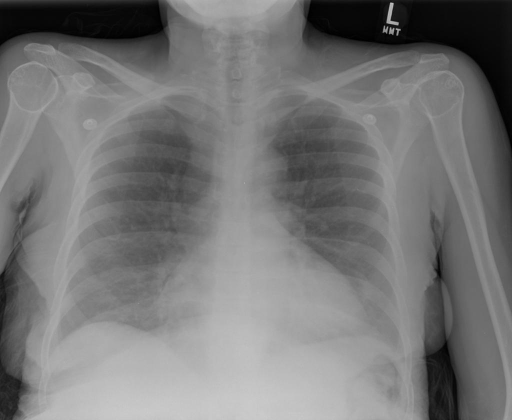

--------------------------------------------------Lateral X-Ray--------------------------------------------------


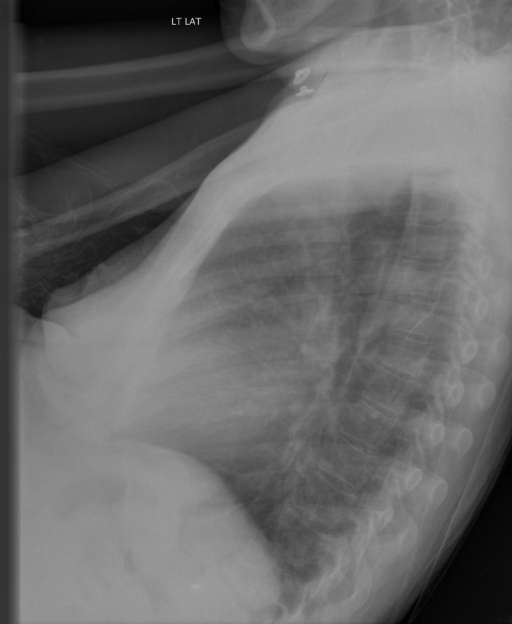

--------------------------------------------------GREEDY_SEARCH--------------------------------------------------
Actual Impression  ['<start> Cardiomegaly with mild bibasilar infiltrates versus atelectasis. <end>']
Generated Impression  ['<start>', 'mild', 'bibasilar', 'infiltrates', 'versus', 'atelectasis', '<end>']
BLEU Score for Greedy search is  0.631914561891573
--------------------------------------------------BEAM_SEARCH--------------------------------------------------
Actual Impression  ['<start> Cardiomegaly with mild bibasilar infiltrates versus atelectasis. <end>']
Generated Impression  ['<start>', 'cardiomegaly', 'with', 'clear', 'lungs', 'with', 'mild', 'bibasilar', 'infiltrates', 'versus', 'atelectasis', '<end>']
BLEU Score for Beam search is  0.6175637907926896


In [22]:
# get a random image pair
data_pair = data_pairs.sample(1)
z = data_pair.values
image_pairs = z[0][1]
# extract the xray files
xray1 = image_pairs[0] + '.png'
xray2 = image_pairs[1] + '.png'
# show the xray pairs
im1 = Image.open(img_path + '/' + xray1)  
im2 = Image.open(img_path + '/' + xray2) 
print('-'*50 + 'Front X-Ray' +  '-'*50)  
display(im1)
print('-'*50 + 'Lateral X-Ray' +  '-'*50)  
display(im2)
# call the final function
result_greedy, result_Beam = final_function(data_pair)

## Conclusions

- In this Notebook we implimented the entire ML Pipeline.
- All the operatios were performed in the final_function method.
- The Pretrained ML Model was used in this case.

## References

- https://www.tensorflow.org/tutorials/text/image_captioning#model
- https://www.tensorflow.org/tutorials/text/nmt_with_attention#write_the_encoder_and_decoder_model
- https://stackoverflow.com/questions/50786987/multiclass-classification-to-balance-in-python-over-sampling
- https://radimrehurek.com/gensim/models/word2vec.html
- https://machinelearningmastery.com/develop-word-embeddings-python-gensim/
- https://machinelearningmastery.com/calculate-bleu-score-for-text-python/
- https://github.com/nagapavan525/radiology-report-generation/blob/master/radiology_report_generation_final/Automated_Radiology_Report_Generation_attention%20(1).ipynb
- https://github.com/nagapavan525/radiology-report-generation/blob/master/NewIntegrationWithIndication/1_Capstone-Radiology-PreProcessing.ipynb
- https://www.crummy.com/software/BeautifulSoup/bs4/doc/
- https://stackoverflow.com/questions/2612548/extracting-an-attribute-value-with-beautifulsoup
- https://stackoverflow.com/questions/24962673/beautiful-soup-getting-tag-id
- https://stackoverflow.com/a/47091490/4084039
- https://www.appservgrid.com/psam/Python_Samplifier--python1compute--Python_Program_to_Find_the_Size_(Resolution)_of_a_Image.html
- https://www.geeksforgeeks.org/working-images-python/
- https://gist.github.com/sebleier/554280
- https://stackoverflow.com/questions/27488446/how-do-i-get-word-frequency-in-a-corpus-using-scikit-learn-countvectorizer
- https://www.geeksforgeeks.org/python-remove-all-digits-from-a-list-of-strings/
- https://stackoverflow.com/questions/12851791/removing-numbers-from-string
- https://github.com/nagapavan525/radiology-report-generation/blob/master/radiology_report_generation_final/AutomatedRadiologyReportGenerationWithSentenceEmbeddings.ipynb
- https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/